# Deep Hedging Review

### Imports

In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from IPython.display import clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall
from deep_hedging import Deep_Hedging_Model, Delta_SubModel
from loss_metrics import Entropy
from utilities import train_test_split

%load_ext autoreload

clear_output()
print("\nFinish installing and importing all necessary libraries!")


Finish installing and importing all necessary libraries!


### Variables used in multiple modules

In [2]:
# Geometric Brownian Motion.
N = 30 # Number of time steps (in days)

S0 = 100.0 # Stock price at time = 0
sigma = 0.2 # Implied volatility
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.

# Day convention.
day_count = ql.Actual365Fixed() # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = 0.0

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Other control flags for development purpose.
mc_simulator = "QuantLib" # "QuantLib" or "Numpy"

### Path generation


Monte Carlo Simulation - Generate Random Paths of Stock Prices

In [3]:
seed = 0 # Random seed. Change to have deterministic outcome.

# Total obs = Training + Testing
nobs = int(Ktrain*(1+Ktest_ratio))

# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date,calculation_date + 1)
maturity = N*dt # Maturities (in the unit of a year)

stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = risk_free, \
                        dividend = dividend, day_count = day_count, seed=seed)

S = stochastic_process.gen_path(maturity, N, nobs)

# clear_output()

print("s0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")

100%|████████████████████████████████| 120000/120000 [00:05<00:00, 20632.04it/s]

s0 = 100.0
sigma = 0.2
risk_free = 0.0

Number of time steps = 30
Length of each time step = 1/365

Simulation Done!


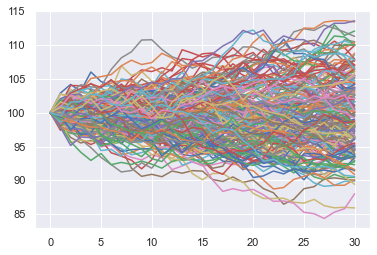

In [4]:
n_path_shown = 200

plt.plot(S.T[:,:200])
plt.show()

### Training data:
- Define an European call option (short)
- Define option paths for $N$ days, S is the array of 31days x 120000 paths
- Build $I$ the information set depending on the choice of information_set chosen from ($S$ ,$log S$, $log_normalized S$)
- Build the training set as a 3 elements:
    - The trade set: [S] which is the path of the options (prices for N dates for 120000 options)
    - Information set: [I] which is either (S ,log S, log_normalized S)
    - payoff (dim = 1): which is at the end, how much we make with this option

We obtain: $xtrain = (S_1, I_1, S_2, I_2, ..., S_{N-1}, I_{N-1}, S_N, payoff)$

In [5]:
# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N


# For each path, at the end, we compute the payoff of the call option, ie val - strike -> positive value
payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set, [N_DAYS, N_PATHS] for each day, each price
print("trade_set (S redim) shape : ", trade_set.shape)


if information_set == "S":
  I =  np.stack((S),axis=1) # Information set
elif information_set == "log_S":
  I =  np.stack((np.log(S)),axis=1)
elif information_set == "normalized_log_S":
  I =  np.stack((np.log(S/S0)),axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S]
#   3) payoff (dim = 1)
x_all = []
for i in range(N+1):
    x_all += [trade_set[i,:,None]]
    if i != N:
        x_all += [I[i,:,None]]
x_all += [payoff_T[:,None]]

print("We have 31 days for the paths S and 31 days for the information set I, so that makes 31*2 days: ", len(x_all))
print("So the set looks like this (S_1, I_1, S_2, I_2, ..., I_N-1, S_N, payoff) is and each element has shape:", x_all[0].shape)

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)
[S_train, S_test] = train_test_split([S], test_size=test_size)
[option_payoff_train, option_payoff_test] = train_test_split([x_all[-1]], test_size=test_size)

trade_set (S redim) shape :  (31, 120000)
We have 31 days for the paths S and 31 days for the information set I, so that makes 31*2 days:  62
So the set looks like this (S_1, I_1, S_2, I_2, ..., I_N-1, S_N, payoff) is and each element has shape: (120000, 1)


### Creating the model

We define our model architecture, call it a strategy layer, we will use such 1 layer for each N days.

The model does the following:
- For each N days: 
    - Creates the input for this day in the same fashion as the training set, in the code, $S_t=prc_t$, $I=information\_set$. So we have for instance $(S_0, I_0)$ for the first day, $(S_2,I_2)$ for the 2nd day...
    
    - Compute the output of the strategy layer on the information_set.
    - Compute the delta\_strategy: $delta\_strategy = strategy_{t+1} - strategy_t$, with $strategy_{-1}$ set to 0. This is the difference between the output of the last strategy strategy_t on the information set 
    
    - Compute the costs for this day, either proportional or constant with attribute epsilon.
    - Computes the wealth of the strategy after this day:         
      The wealth for the next period is $w_{t+1} = w_t + (strategy_t-strategy_{t+1})*prc_t = w_t - delta\_strategy*prc_t$
    - Also accumulate the interest rate for the next period ($FV\_factor = np.exp(risk\_free*dt)$), we do wealth = wealth * FV\_factor
    
    - Append the input to inputs, so for instance append $(S_3, I_3)$ to $inputs=(S_1, I_1, S_2, I_2)$
    
    
- On the last day:
    - Compute the final wealth as wealth_N = wealth_{N-1} + payoff
    - Append the terminal payoff to the inputs.
    
We obtain: $inputs = (S_0, I_0, S_1, I_1, ..., I_{N-2}, S_{N-1}, payoff)$, in the code (just add +1 to these indexes to see it fits with out training set).

- We finally create the model with these inputs, and the final wealth as output.

So the model takes as input the previously defined training set, and tries to optimize the wealth in the end, ie:
The StrategyLayer will try to weight the options...

### Running the model

At each epoch, we run the model on our training data and get a resulting wealth. 
We compute the loss function of this wealth (Entropy / CVar).

For the test data, we compute the resulting predicted wealth (=output of our model). And plot it by wealth + initial price BS (computed as the price of the option according to the Black Scholes model, with the given parameters for the option)
ie : if the predicted wealth by the model is the same as Black-Scholes price, we thus can replicate Black Scholes' delta, then we are centered around 0 in the PnL plot.

To have a better hedge than the Black Scholes model, we would need to have a PnL plot shifted to the right.


##### Model parameters

In [6]:
# Geometric Brownian Motion.
N = 30 # Number of time steps (in days)

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda 

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 1 # Number of hidden layers (Note including input nor output layer)         

# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=50 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

delta_constraint = (0.0, 1.0)
share_stretegy_across_time = False
cost_structure = "proportional"

# Other control flags for development purpose.
mc_simulator = "QuantLib" # "QuantLib" or "Numpy"

In [7]:
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_simple = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="simple", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost, delta_constraint = delta_constraint, \
          share_stretegy_across_time = share_stretegy_across_time, \
          cost_structure = cost_structure)
loss = Entropy(model_simple.output,None,loss_param) # (1/loss_param)*K.log(K.mean(K.exp(-loss_param*wealth)))
model_simple.add_loss(loss)

model_simple.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_simple.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
          validation_data=xtest, verbose=1)

clear_output()

print("Finished running deep hedging algorithm! (Simple Network)")

Finished running deep hedging algorithm! (Simple Network)
